In [1]:
import torch
import numpy as np
from diffusers import DDPMPipeline
import matplotlib.pyplot as plt 
import torch.nn as nn
from torchvision import datasets, transforms

from MCGDiff import NoiselessBackwardFK, PseudoSMC

/home/perann/miniconda3/envs/smc_sampling/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/perann/miniconda3/envs/smc_sampling/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


MNIST Dataset

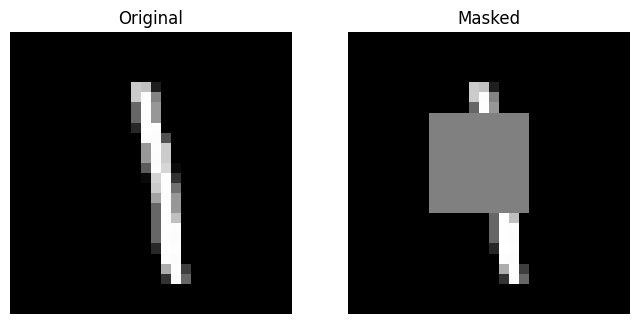

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load MNIST 
mnist = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())
x0, label = mnist[31]
x0 = x0.numpy().squeeze()

# Mask
x0 = x0 * 2.0 - 1.0  


mask = np.ones_like(x0)
mask[8:18,8:18] = 0
masked_img = x0 * mask 

# Flatten for SMC
x0_flat = x0.flatten()
mask_flat = mask.flatten().astype(bool)
obs_idx = np.where(mask_flat)[0]
miss_idx = np.where(~mask_flat)[0]
y_obs = x0_flat[obs_idx]
dx = x0_flat.size
dy = len(obs_idx)

# test
def to_img(x):
    return (x + 1.0) / 2

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow(to_img(x0), cmap="gray"); ax[0].set_title("Original"); ax[0].axis("off")
ax[1].imshow(to_img(masked_img), cmap="gray"); ax[1].set_title("Masked"); ax[1].axis("off")
plt.show()

# Importing a pre trained model

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist")
pipe = pipe.to(device)

unet = pipe.unet              
scheduler = pipe.scheduler    

betas = scheduler.betas.to(device)                 
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)          
sigmas = torch.sqrt(betas)                         


# Keeping numpy for code base
alpha_bars_np = alpha_bars.detach().cpu().numpy()
alpha_np = alphas.detach().cpu().numpy()
sigmas_np = sigmas.detach().cpu().numpy()


Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 14.53it/s]


In [4]:
def to_img(x):
    return (x + 1.0) / 2.0

class DiffusersEpsWrapper(nn.Module):
    def __init__(self, unet, scheduler):
        super().__init__()
        self.unet = unet
        self.scheduler = scheduler

    def forward(self, x, t):
        out = self.unet(x, t)
        return out.sample if hasattr(out, "sample") else out

eps_model = DiffusersEpsWrapper(unet, scheduler).to(device).eval()

Step 195: 5 valid, 0 degenerate particles
Step 190: 5 valid, 0 degenerate particles
Step 185: 5 valid, 0 degenerate particles
Step 180: 5 valid, 0 degenerate particles
Step 175: 5 valid, 0 degenerate particles
Step 170: 5 valid, 0 degenerate particles
Step 165: 5 valid, 0 degenerate particles
Step 160: 5 valid, 0 degenerate particles
Step 155: 5 valid, 0 degenerate particles
Step 150: 5 valid, 0 degenerate particles
Step 145: 5 valid, 0 degenerate particles
Step 140: 5 valid, 0 degenerate particles
Step 135: 5 valid, 0 degenerate particles
Step 130: 5 valid, 0 degenerate particles
Step 125: 5 valid, 0 degenerate particles
Step 120: 5 valid, 0 degenerate particles
Step 115: 5 valid, 0 degenerate particles
Step 110: 5 valid, 0 degenerate particles
Step 105: 5 valid, 0 degenerate particles
Step 100: 5 valid, 0 degenerate particles
Step 95: 5 valid, 0 degenerate particles
Step 90: 5 valid, 0 degenerate particles
Step 85: 5 valid, 0 degenerate particles
Step 80: 5 valid, 0 degenerate partic

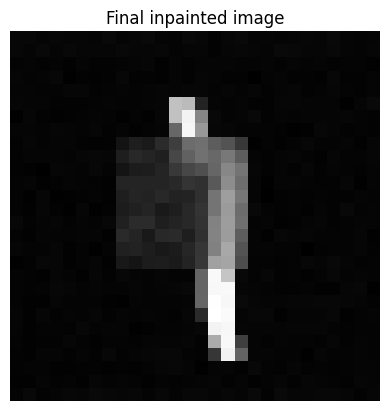

In [5]:
fk = NoiselessBackwardFK(y=y_obs, obs_idx=obs_idx, miss_idx=miss_idx,
                          alpha_bars=alpha_bars_np, sigmas=sigmas_np,
                          model=eps_model, dx=dx)

smc = PseudoSMC(fk, N=5)
particles_final = smc.run(snapshot_every=5)

# --- Show final reconstruction ---
recon = particles_final.mean(axis=0).reshape(28,28)
recon = particles_final[0].reshape(28,28)
recon = to_img(recon)
plt.imshow(recon, cmap="gray")
plt.title("Final inpainted image")
plt.axis("off")
plt.show()

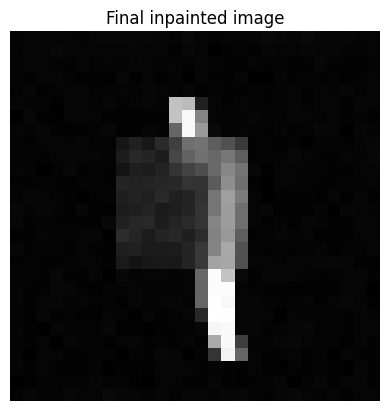

In [9]:
recon = particles_final[3].reshape(28,28)
recon = particles_final[3].reshape(28,28).copy()
plt.imshow(to_img(recon), cmap="gray")
plt.title("Final inpainted image")
plt.axis("off")
plt.show()

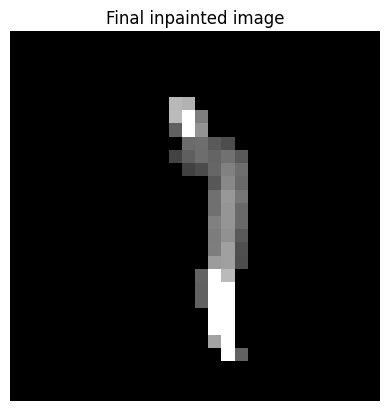

In [ ]:
recon[recon <= -0.5] = -1.0
recon[recon >= 0.5] = 1.0
plt.imshow(to_img(recon), cmap="gray")
plt.title("Final inpainted image")
plt.axis("off")
plt.show()